<h1 align="center">Model selection</h1>

Libraries

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import PredefinedSplit
import pyarrow.parquet as pq
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from evaluation_functions import *


<h2 style="text-align: left;">Understanding the problem</h2>


Download data

In [55]:
parquet_file_path = '/home/oscar/data/feature_frame.parquet'
data = pq.read_table(parquet_file_path).to_pandas()
data.shape

(2880549, 27)

This sampling process is employed due to the large size of the dataset and the memory constraints that often lead to kernel crashes. To address this issue, we implement a sampling technique. However, instead of conducting random sampling, which could inadvertently remove specific products from transactions and introduce biases, we opt for a more structured approach.

We base our sampling on orders, ensuring that entire transactions are included in the sample. This method preserves the integrity of the data and prevents distortions that might arise from other sampling methods. By randomly selecting orders to include in our sample, we create a representative subset of the dataset that is smaller in size and more manageable for analysis.

In [56]:
order_ids = data['order_id'].unique()
sample_percentage = 0.2  

sample_orders_amount = int(len(order_ids) * sample_percentage)

sampled_orders = np.random.choice(order_ids, size=sample_orders_amount, replace=False)

sampled_data = data[data['order_id'].isin(sampled_orders)]

print("Original dataset size:", data.shape)
print("Sampled dataset size:", sampled_data.shape)

Original dataset size: (2880549, 27)
Sampled dataset size: (575383, 27)


In [57]:
data = sampled_data

Firstly, we have to select those orders which contain at least 5 items, so we can filter the Data Frame owing to this specification. 

In [58]:
num_products_ordered = data.groupby('order_id')['outcome'].sum()
orders_with_5_or_more_unique_products = num_products_ordered[num_products_ordered>=5].index

filtered_data = data[data['order_id'].isin(orders_with_5_or_more_unique_products)]

print(f"Number of total orders: {data['order_id'].nunique()}")
print(f"Number of orders with more than 5 products: {filtered_data['order_id'].nunique()}")

Number of total orders: 689
Number of orders with more than 5 products: 528


<h2 style="text-align: left;">Feature Selection</h2>

In [59]:
target = ['outcome']
id_features = ['variant_id', 'order_id', 'user_id']
temporal_features = ['created_at', 'order_date']
binary_features = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
categorical_features = ['product_type', 'vendor'] 
non_numerical_features = target + id_features+ temporal_features + categorical_features

numerical_features = [feature for feature in filtered_data.columns if feature not in non_numerical_features]

**IDENTIFICATION FEATURES**

The identifying variables, order_id, user_id, and variant_id, serve to uniquely identify orders, users, and variants in the dataset. However, they do not possess any predictive power regarding the outcome of interest. Therefore, these identifying variables will not appear in the final dataset used for predictive modeling or analysis. 

In [60]:
features_to_remove = id_features

**TEMPORAL FEATURES**

In the "temporal_features" section, it's noted that the two temporal variables are of type "object." This observation is crucial because it highlights that these variables are stored as strings rather than datetime objects. It's essential to keep this in mind when reading the dataset to ensure proper conversion into the datetime format.

Converting these variables into the datetime format is important for several reasons, particularly when performing tasks such as time series analysis, feature engineering, or data splitting into training and testing sets.

In [61]:
filtered_data.loc[:,'order_date'] = pd.to_datetime(filtered_data.loc[:,'order_date'])
filtered_data.loc[:,'created_at'] = pd.to_datetime(filtered_data.loc[:,'created_at'])

There features represent essentially the same information, where 'order_date' and 'created_at' both capture temporal data. However, 'created_at' includes the time component in addition to the date, while 'order_date' only represents the date without the time.

In [62]:
features_to_remove.append('created_at')
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at']


**BINARY FEATURES**

We initially considered aggregating these binary variables in some way, but it has been observed that they are not highly correlated with each other. Moreover, some individual variables, such as 'abandoned_before,' exhibit significant importance on their own for predicting the response variable.

In [63]:
print(filtered_data.groupby('abandoned_before')['outcome'].mean() * 100)

abandoned_before
0.0     1.398652
1.0    75.517241
Name: outcome, dtype: float64


When 'abandoned_before' is 0.0, indicating that the customer has not abandoned an order before, the mean purchase rate is approximately 1.39%. Conversely, when 'abandoned_before' is 1.0, indicating that the customer has previously abandoned an order, the mean purchase rate drastically increases to approximately 75.08%. This substantial difference in purchase rates suggests that the 'abandoned_before' variable holds considerable predictive power on its own in determining the likelihood of purchase.

In [64]:
print("Correlation Matrix between binary features:")
print(filtered_data[binary_features].corr())

Correlation Matrix between binary features:
                  ordered_before  abandoned_before  active_snoozed  \
ordered_before          1.000000          0.037184        0.264045   
abandoned_before        0.037184          1.000000        0.013331   
active_snoozed          0.264045          0.013331        1.000000   
set_as_regular          0.308033          0.000943        0.089247   

                  set_as_regular  
ordered_before          0.308033  
abandoned_before        0.000943  
active_snoozed          0.089247  
set_as_regular          1.000000  


**CATEGORICAL FEATURES**

The initial intention is to encode these variables by frequency. However, it's not feasible to perform this encoding directly on the initial dataset. Instead, it must be done separately for each split. This approach is necessary to prevent data leakage or contamination between the splits, which could lead to an overly optimistic estimation of model performance.

**NUMERICAL FEATURES**

The correlation matrices provide insights into linear relationships between variables, but it's important to note that non-linear relationships may exist, which are not captured by these matrices. Given this context, observing the correlation matrix provided, we can make several observations:

* The variables "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id" show moderate correlation with "days_since_purchase_variant_id."

* The variable "days_since_purchase_product_type" displays moderate correlation with "days_since_purchase_variant_id." 

* The variable "avg_days_to_buy_product_type" exhibits moderate correlation with "avg_days_to_buy_variant_id" and "std_days_to_buy_variant_id." 

Despite these observations, it's essential to remember that correlation matrices do not capture all relationships between variables, especially non-linear ones. Therefore, no variables will be eliminated at this point due to the possibility of non-linear relationships not reflected in these matrices.

In [65]:
print(filtered_data[[
    'days_since_purchase_variant_id',
    'avg_days_to_buy_variant_id',
    'std_days_to_buy_variant_id',
    'days_since_purchase_product_type',
    'avg_days_to_buy_product_type',
    'std_days_to_buy_product_type',
    'outcome'
]].corr())

                                  days_since_purchase_variant_id  \
days_since_purchase_variant_id                          1.000000   
avg_days_to_buy_variant_id                              0.025450   
std_days_to_buy_variant_id                              0.028620   
days_since_purchase_product_type                        0.209006   
avg_days_to_buy_product_type                            0.007646   
std_days_to_buy_product_type                            0.008994   
outcome                                                 0.027495   

                                  avg_days_to_buy_variant_id  \
days_since_purchase_variant_id                      0.025450   
avg_days_to_buy_variant_id                          1.000000   
std_days_to_buy_variant_id                          0.596280   
days_since_purchase_product_type                    0.001743   
avg_days_to_buy_product_type                        0.292059   
std_days_to_buy_product_type                        0.251979   
outcome

Variables related to family members were likely imputed mostly with the median, as observed in the exploratory data analysis (EDA). However, due to this imputation strategy, they may introduce more noise than information into the dataset. Therefore, they will not be used in the analysis.

In [66]:
features_to_remove.extend(['count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby'])
print(features_to_remove)

['variant_id', 'order_id', 'user_id', 'created_at', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby']


**FINAL DATA**

In [67]:
final_data = filtered_data.drop(features_to_remove, axis=1)

<h2 style="text-align: left;">Getting training, validation and testing</h2>

**INITIAL SPLITTING (FINALLY NOT USED)**

In order to avoid information leakage, we must consider several key factors:
* We have to ensure that the same 'user_id' does not appear in both the training and testing datasets is crucial. This can lead to data leakage, compromisiing the integrity of the evaluation.
* It's essential to mantain the assumption that the training and testing datasets are independentrly and identically distributed to ensure the model's performance on the test data accurately reflexts its ability to generalize to unseen data

As we have **an imbalanced dataset**, we'll split the dataset into training and testing sets using **stratification**, and based on avoiding information leakage by user.

In [13]:
unique_users = data['user_id'].unique()
train_users, test_users = train_test_split(unique_users, test_size=0.2)

In [14]:
train_data = data[data['user_id'].isin(train_users)]
test_data = data[data['user_id'].isin(test_users)]

In [15]:
X_train = train_data.drop('outcome', axis=1)
y_train = train_data['outcome']

X_test = test_data.drop('outcome', axis=1)
y_test = test_data['outcome']

In [16]:
print("Train set size:", len(train_data)/(len(train_data)+len(test_data)))
print("Test set size:", len(test_data)/(len(train_data)+len(test_data)))

Train set size: 0.7969782843478795
Test set size: 0.2030217156521205


Overall, the proportion of examples for each class is maintained well between the train and test sets. Despite the class imbalance, the proportion remains consistent across both sets. This suggests that stratifying the data during the train-test split may not be necessary in this case, as the imbalance is preserved in both sets without intervention. However, it's important to note that this imbalance might affect the performance of some classifiers, and strategies such as oversampling or undersampling of the minority class may be considered to address this issue.

In [17]:
train_class_percentages = train_data['outcome'].value_counts(normalize=True) * 100
test_class_percentages = test_data['outcome'].value_counts(normalize=True) * 100

print("Percentage of examples for each class in train set:")
print(train_class_percentages)
print("\nPercentage of examples for each class in test set:")
print(test_class_percentages)

Percentage of examples for each class in train set:
outcome
0.0    98.842506
1.0     1.157494
Name: proportion, dtype: float64

Percentage of examples for each class in test set:
outcome
0.0    98.861347
1.0     1.138653
Name: proportion, dtype: float64


The approach described above was a way to split the data without considering the temporal reference. Initially, I assumed that temporal information might not be crucial as there was already data available on the days since the last purchase, etc. However, upon further consideration, I realized the importance of incorporating temporal information into the data splitting process.

To address this, I devised another approach for splitting the data based on this temporal reference. This new approach involves dividing the dataset into training and testing sets while ensuring that the temporal sequence is preserved. By doing so, we aim to account for any temporal dependencies or patterns in the data, which may be critical for accurately modeling and predicting future outcomes.

**NEW SPLITTING**

When separating data, it's crucial to consider the date on which orders are placed for several reasons. Firstly, the temporal aspect provides valuable insights into patterns and trends over time, which can significantly impact the performance of predictive models. By incorporating temporal information into the data splitting process, we ensure that the training data represents past observations, while the testing or validation data represents future observations, mimicking real-world scenarios.

Moreover, not considering the date of orders can lead to a phenomenon known as data leakage. Data leakage occurs when information from the future or unseen data is inadvertently included in the training process, leading to overly optimistic performance estimates of the model. In the context of order data, if future information, such as orders placed after a certain date, is included in the training set, the model may learn patterns that do not generalize well to unseen data, resulting in poor model performance when deployed in production.

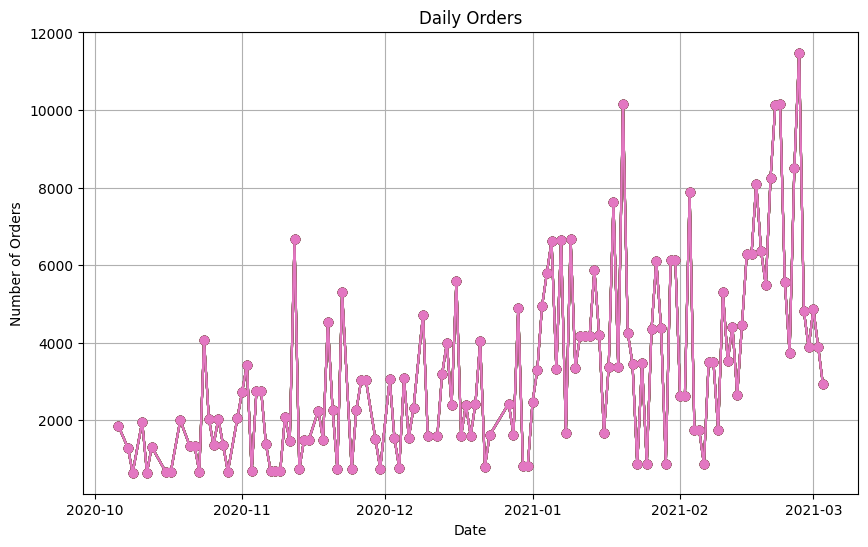

In [68]:
daily_orders = final_data.groupby('order_date').count()
plt.figure(figsize=(10, 6)) 
plt.plot(daily_orders, marker='o', linestyle='-')  
plt.title('Daily Orders')  
plt.xlabel('Date')  
plt.ylabel('Number of Orders')
plt.grid(True) 
plt.show()

Firstly, we should conduct research regarding date information:

In [70]:
print("Minimum order date:", final_data['order_date'].min())
print("Maximum order date:", final_data['order_date'].max())

Minimum order date: 2020-10-06 00:00:00
Maximum order date: 2021-03-03 00:00:00


The criterion followed for the separation is based on dividing the data into three sets: training, validation, and testing, while maintaining a temporal relationship among them. This approach ensures that the model is trained on data from an earlier period than the validation and testing data.

Specifically, the data is divided into three parts using quantiles based on the order dates. Approximately 70% of the data is allocated to the training set, while approximately 15% each is allocated to the validation and testing sets. This allocation strategy considers the distribution of orders over time, aiming to prevent information contamination between sets.

Adhering to this temporal relationship is crucial for preventing the model from learning patterns specific to the validation and testing data, thus promoting its generalization ability to unseen data effectively. Moreover, allocating a larger portion of data to training ensures that the model learns from a diverse range of examples, which enhances its overall performance and robustness.

In [120]:
final_data_sorted = final_data.sort_values(by='order_date')

train_end = final_data_sorted['order_date'].quantile(0.7)
val_end = final_data_sorted['order_date'].quantile(0.85)
test_end = final_data_sorted['order_date'].quantile(1)


train_data = final_data_sorted[final_data_sorted['order_date'] < train_end]
val_data = final_data_sorted[(final_data_sorted['order_date'] >= train_end) & (final_data_sorted['order_date'] < val_end)]
test_data = final_data_sorted[(final_data_sorted['order_date'] >= val_end) & (final_data_sorted['order_date'] <= test_end)]

print("Training set size:", (train_data.shape[0] / final_data_sorted.shape[0]))
print("Validation set size:", (val_data.shape[0] / final_data_sorted.shape[0]))
print("Testing set size:", (test_data.shape[0] / final_data_sorted.shape[0]))

Training set size: 0.6968283049992813
Validation set size: 0.14354652131157267
Testing set size: 0.15962517368914605


These dates represent the end points of each subset:

* The training set ends on February 9, 2021, at midnight.
* The validation set ends on February 21, 2021, at midnight.
* The testing set ends on March 3, 2021, at midnight.

**Possible issue**: What if I have a user who makes purchases in both the training and testing sets? Will the model learn from that user? Is there a risk of data leakage?

In [127]:
X_train = train_data.drop(columns=['outcome', 'order_date'])
y_train = train_data['outcome']

X_val = val_data.drop(columns=['outcome', 'order_date'])
y_val = val_data['outcome']

X_test = test_data.drop(columns=['outcome', 'order_date'])
y_test = test_data['outcome']

<h2 style="text-align: left;">Data training</h2>

1. **Logistic Regression l2 - Ridge**

Before diving into model training, we undertake a preprocessing step known as encoding, specifically tailored for categorical features. 

In this context, we employ a technique called Count Encoding, which involves replacing categorical values with the frequency of their occurrences within the dataset. Unlike One-Hot Encoding, which can lead to an explosion in the number of features, especially when dealing with categorical features with numerous unique values, Count Encoding mitigates this issue by providing a compact representation of categorical data.

Moreover, we opt against using Target Encoding at this stage due to potential concerns related to class imbalance. Target Encoding, which involves replacing categorical values with the mean of the target variable within each category, may risk overfitting, particularly when dealing with imbalanced classes.

In [128]:
columns_to_encode = categorical_features

column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', ce.CountEncoder(min_group_size=1.0), columns_to_encode)
    ],
    remainder='passthrough' 
)

After encoding categorical variables, we perform variable normalization, a crucial step in logistic regression, primarily due to its sensitivity to the scale of the features.Moreover, Ridge regularization is employed as the initial regularization technique in our model pipeline. This is done to address potential issues such as overfitting and multicollinearity.

Ridge regularization adds a penalty term to the coefficient estimates during model training, which helps prevent overfitting by reducing the magnitude of the coefficients. By starting with Ridge regularization, we ensure that no variables are overly penalized initially, allowing the model to learn from the data more effectively.
Moreover, Ridge regularization is particularly useful for managing multicollinearity.


To optimize the model, we aim to find the highest F1-score due to three main reasons:
* The dataset is imbalanced
* We are interested in correctly identifying positive cases. The F1-score takes into account both precision (the ability to correctly identify positive cases among all predicted positives) and recall (the ability to capture all positive cases among all actual positives), providing a holistic assessment of the model's ability to detect positive instances.

* We aim to avoid oversaturating users with unnecessary alerts: While it is essential to correctly identify positive instances, we also want to minimize false positives to avoid inundating users with unnecessary alerts or recommendations. By optimizing for F1-score, we strike a balance between correctly identifying positive cases and minimizing false positives, ensuring a more user-friendly and effective application of the model.

In [131]:
pipe = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='newton-cg', penalty='l2'))
])


reg_values = np.geomspace(0.00001, 1e+4, num=10)
parameters = {'reg__C': 1.0/reg_values}

gridsearch = GridSearchCV(pipe, parameters,  
                          scoring='f1', 
                          return_train_score=True)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         CountEncoder(combine_min_nan_groups=True,
                                                                                      min_group_size=1.0),
                                                                         ['product_type',
                                                                          'vendor'])])),
                                       ('scaler', StandardScaler()),
                                       ('reg',
                                        LogisticRegression(solver='newton-cg'))]),
             param_grid={'reg__C': array([1.e+05, 1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02,
       1.e-03, 1.e-04])},
             return_train_score=True, scoring='f1')

In [132]:
import pandas as pd

results = pd.DataFrame(gridsearch.cv_results_)

results = results[['param_reg__C', 'param_polynomial_features__degree', 'mean_train_score', 'mean_test_score']]
results.rename(columns={'param_reg__C': 'C', 'param_polynomial_features__degree': 'Degree'}, inplace=True)

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results)


          C  mean_train_score  mean_test_score
9    0.0001          0.080148         0.105789
8     0.001          0.114887         0.132144
7      0.01          0.116140         0.133191
6       0.1          0.116369         0.133254
5       1.0          0.116357         0.133630
4      10.0          0.116357         0.133630
3     100.0          0.116345         0.133630
2    1000.0          0.116345         0.133630
1   10000.0          0.116345         0.133630
0  100000.0          0.116345         0.133630


In [135]:
model_1 =  Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='newton-cg', penalty='l2', C = 1.0))
])
model_2 = Pipeline([
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler()),
    ('reg', LogisticRegression(solver='newton-cg', penalty='l2', C = 10000.0))
])

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)

confusion_1 = confusion_matrix(y_test, pred_1)
confusion_2 = confusion_matrix(y_test, pred_2)

print("Confusion matrix for model with C=1.0:")
print(confusion_1)

print("\nConfusion matrix for model with C=10000.0:")
print(confusion_2)

Confusion matrix for model with C=1.0:
[[68922    99]
 [  884    56]]

Confusion matrix for model with C=10000.0:
[[68922    99]
 [  884    56]]


In [24]:
mejor_estimador=gridsearch.best_estimator_
print('El mejor valor de lambda es:', 1/mejor_estimador['reg'].C)
print('El error en validación sería:',gridsearch.best_score_) 

El mejor valor de lambda es: 1000.0
El error en validación sería: 0.035725757386570405


In [25]:
# Se obtiene el mejor modelo y se evalua su calidad
bestMethod = gridsearch.best_estimator_
prediccion_test = bestMethod.predict(X_test)
fscore_test = metrics.f1_score(y_test, prediccion_test)*100

print('El Fscore en test del mejor modelo es {:.2f}'.format(fscore_test))
print(metrics.confusion_matrix(y_test, prediccion_test, labels=[1,0]))
# La clase positiva no funciona bien, por eso el fscore es bajo

El Fscore en test del mejor modelo es 12.92
[[   56   644]
 [  111 48476]]
